# Quantum kernel training
*Usage estimate: under 1 minute on IBM Nazca (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

In this tutorial, we will show how to build a `Qiskit Pattern` for evaluating entries into a quantum kernel matrix used for binary classification. For more information on `Qiskit Patterns` and how `Qiskit Serverless` can be used to deploy them to the cloud for managed execution, visit our [docs page on the IBM Quantum Platform](https://docs.quantum.ibm.com/run/quantum-serverless).

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)

## Setup

In [2]:
!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

# General Imports and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import UnitaryOverlap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# from qiskit_serverless import IBMServerlessClient, QiskitFunction
from qiskit_ibm_catalog import QiskitServerless, QiskitFunction


def visualize_counts(res_counts, num_qubits, num_shots):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = res_counts.get(0, 0.0)
    top_10 = dict(
        sorted(res_counts.items(), key=lambda item: item[1], reverse=True)[
            :10
        ]
    )
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    x_vals, y_vals = list(zip(*by_key.items()))
    x_vals = [bin(x_val)[2:].zfill(num_qubits) for x_val in x_vals]
    y_vals_prob = []
    for t in range(len(y_vals)):
        y_vals_prob.append(y_vals[t] / num_shots)
    y_vals = y_vals_prob
    plt.bar(x_vals, y_vals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Probability")
    plt.show()


def get_training_data():
    """Read the training data."""
    df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
    training_data = df.values[:20, :]
    ind = np.argsort(training_data[:, -1])
    X_train = training_data[ind][:, :-1]

    return X_train



7[Files: 0  Bytes: 0  [0 B/s] Re]87[https://raw.githubusercontent.]87Saving 'dataset_graph7.csv.1'
87dataset_graph7.csv.1 100% [=============================>]   20.25K    --.-KB/s87HTTP response 200  [https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv]
87dataset_graph7.csv.1 100% [=============================>]   20.25K    --.-KB/s87[Files: 1  Bytes: 20.25K [93.33]8

## Step 1: Map classical inputs to a quantum problem

*   Input: Training dataset.
*   Output: Abstract circuit for calculating a kernel matrix entry.

Create the quantum circuit used to evaluate one entry in the kernel matrix. We use the input data to determine the rotation angles for the circuit's parametrized gates. We will use data samples `x1=14` and `x2=19`.

***Note: The dataset used in this tutorial can be downloaded [here](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/data/dataset_graph7.csv).***

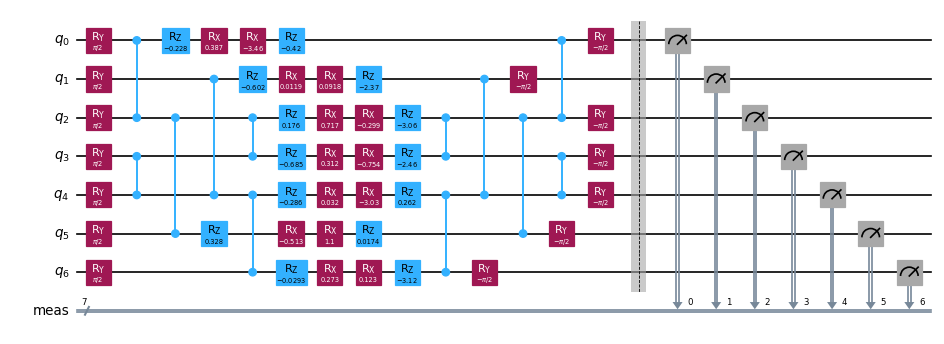

In [3]:
# Prepare training data
X_train = get_training_data()

# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)

# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

# Assign tunable parameter to known optimal value and set the data params for first two samples
x1 = 14
x2 = 19
unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

# Create the overlap circuit
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()
overlap_circ.draw("mpl", scale=0.6, style="iqp")

## Step 2: Optimize problem for quantum hardware execution

*   Input: Abstract circuit, not optimized for a particular backend
*   Output: Target circuit and observable, optimized for the selected QPU

Use the `generate_preset_pass_manager` function from Qiskit to specify an optimization routine for our circuit with respect to the QPU on which we plan to run the experiment. We set `optimization_level=3` , which means we will use the preset pass manager which provides the highest level of optimization.

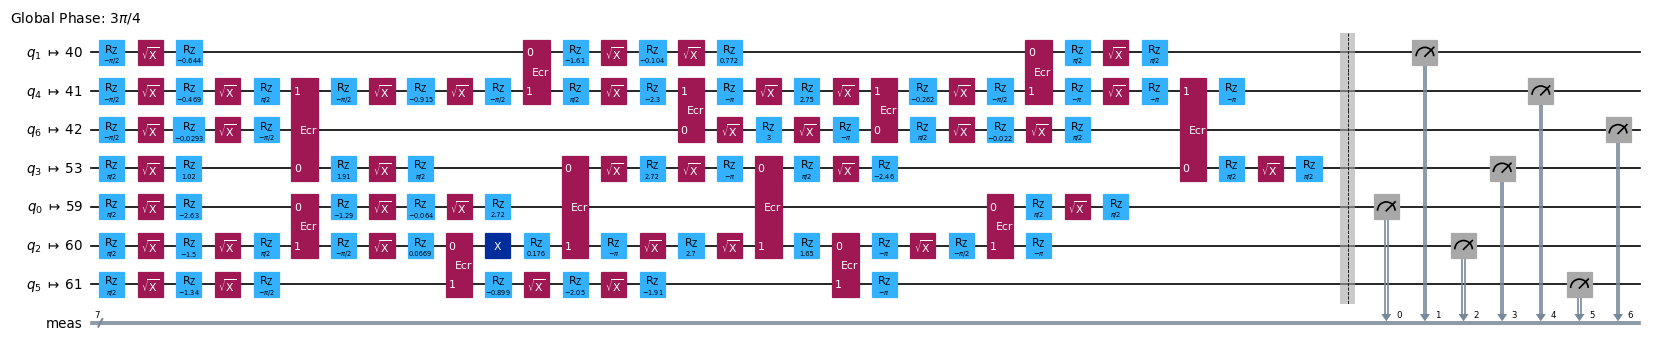

In [4]:
# Remember to insert your token in the QiskitRuntimeService constructor
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=overlap_circ.num_qubits
)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)
overlap_ibm.draw("mpl", scale=0.6, idle_wires=False, fold=-1, style="iqp")

## Step 3: Execute using Qiskit primitives

*   Input: Target circuit
*   Output: Quasi-probability distribution

Use the `Sampler` primitive from Qiskit Runtime to reconstruct a quasi-probability distribution of states yielded from sampling the circuit. For the task of generating a kernel matrix, we are particularly interested in the probability of measuring the |0> state.

Since we optimized the circuit for the backend in Step 2, we can avoid doing transpilation on the Runtime server by setting `skip_transpilation=True` and passing the optimized circuit to the `Sampler`. For this demo, we will run on a QPU with `qiskit-ibm-runtime` primitives. To run on `qiskit` statevector-based primitives, replace the block of code using Qiskit IBM Runtime primitives with the commented block.

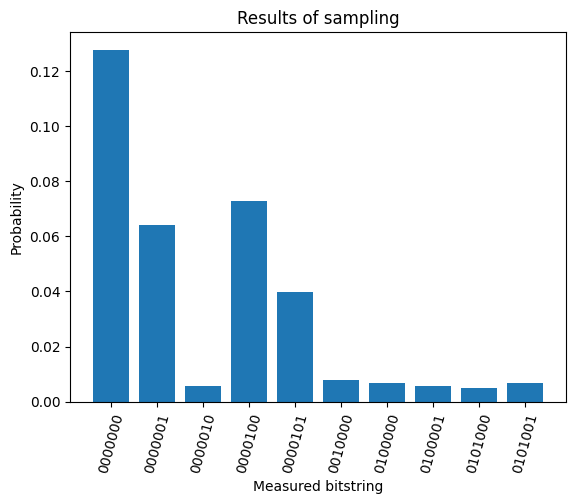

In [6]:
num_shots = 10_000

## Evaluate the problem using statevector-based primitives from Qiskit
# from qiskit.primitives import StatevectorSampler

# sampler = StatevectorSampler()
# results = sampler.run([overlap_circ]).result()
# counts = results[0].data.meas.get_int_counts()

# Evaluate the problem using a QPU via Qiskit IBM Runtime

sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm]).result()
counts = results[0].data.meas.get_int_counts()

visualize_counts(counts, num_qubits, num_shots)

## Step 4: Post-process and return result in desired classical format

*   Input: Probability distribution
*   Output: A single kernel matrix element

Calculate the probability of measuring |0> on the overlap circuit, and populate the kernel matrix in the position corresponding to the samples represented by this particular overlap circuit (row 15, column 20). In this visualization, darker red indicates fidelities closer to 1.0. To fill out the entire kernel matrix, we need to run a quantum experiment for each entry.

In [7]:
# Calculate the fidelity, or the probability to measure 0
kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
print(f"Fidelity: {kernel_matrix[x1, x2]}")

Fidelity: 0.1279


![kernel_matrix.png](/images/tutorials/quantum-kernel-training/kernel_matrix.avif)

## Deploy the Qiskit Pattern to the cloud

To do this, move the source code above to a file, `./source/generate_kernel_entry.py`, wrap the code in a script which takes inputs returns the final solution, and finally upload it to a remote cluster using the `QiskitFunction` class from `Qiskit Serverless`. For guidance on specifying external dependencies, passing input arguments, and more, check out the [Qiskit Serverless guides](https://qiskit.github.io/qiskit-serverless/getting_started/index.html).

The input to the Pattern is a pair of data samples, `x1` and `x2`. The output is the fidelity between the two samples. This value will be used to populate the kernel matrix entry corresponding to these two samples.

In [ ]:
serverless = QiskitServerless()

kernel_entry_pattern = QiskitFunction(
    title="generate-kernel-entry",
    entrypoint="generate_kernel_entry.py",
    working_dir="./source/",
)

serverless.upload(kernel_entry_pattern)

## Run the Qiskit Pattern as a managed service

Once we have uploaded the pattern to the cloud, we can easily run it using the `IBMServerlessProvider` client. For simplicity, we will use an exact quantum simulator in the cloud environment, so the fidelity we calculate will be exact.

In [ ]:
generate_kernel_entry = serverless.load("generate-kernel-entry")
job = generate_kernel_entry.run(
    sample1=list(X_train[x1]), sample2=list(X_train[x2])
)

kernel_matrix[x1, x2] = job.result()["fidelity"]
print(f"fidelity: {kernel_matrix[x1, x2]}")

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_6xsFvUYV1pNHCqW)

© IBM Corp. 2024, 2025